# Importing Required Librarires

In [34]:
%matplotlib inline
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Loading Data

The data files were preprocessed on PySpark (10 nodes) cluster. The code for the same can be found [here](.emr_processing/DataProcessing.ipynb). The preprocessed is a numpy array with `4144531` rows with following columns (zero-indexed):
* Col 0-9: projections on first 10 eigen vectors
* Col 10: rmse
* Col 11: peak2peak
* Col 12: label (`0 if row.species==u'Gervais' else 1`)

In [35]:
data  = np.load("data.np")
X = data[:, :-1]
y = np.array(data[:, -1], dtype=int)

# Train - Test - Validation

The data is shuffled and divided as follow:
* Training: 70%
* Validation: 15%
* Testing: 15%

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

# Model Training

## Setting Parameters for XG Boost
* Maximum Depth of the Tree = 3 _(maximum depth of each decision trees)_
* Step size shrinkage used in update to prevents overfitting = 0.3 _(how to weigh trees in subsequent iterations)_
* Evaluation Criterion= `Maximize Loglikelihood` _(maximizing cross entropy)_
* Maximum Number of Iterations = 1000 _(total number trees for boosting)_
* Early Stop if score on Validation does not improve for 5 iterations

In [37]:
param = {'max_depth': 3, 'eta': 0.3, 'silent': 0, 'objective': 'binary:logistic'}

# total number of cores to use
param['nthread'] = 7 
param['eval_metric'] = 'logloss'

plst = param.items()
evallist = [(dtrain, 'train'), (dtest, 'eval')]

In [46]:
# bst is model with 100 iterations
num_round = 100
bst = xgb.train(plst, dtrain, num_round, evallist, early_stopping_rounds=5, verbose_eval=False)

# bst1000 is model with 1000 iterations
num_round = 1000
bst1000 = xgb.train(plst, dtrain, num_round, evallist, early_stopping_rounds=5, verbose_eval=False)

## Visualize the Feature Importance

In [40]:
def visualize_features(bst, features_map = None):
    xgb.plot_importance(bst)
    plt.show()
    if features_map:
        print("Feature Mapping:")
        for x in features_map:
            print(x, "\t: ", features_map[x])

100 Iterations


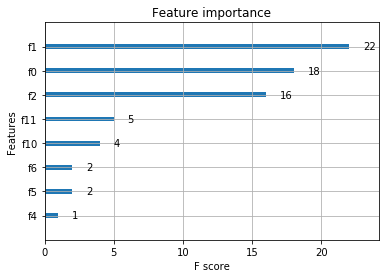

Feature Mapping:
f0 	:  Eigen Projection 1
f1 	:  Eigen Projection 2
f2 	:  Eigen Projection 3
f3 	:  Eigen Projection 4
f4 	:  Eigen Projection 5
f5 	:  Eigen Projection 6
f6 	:  Eigen Projection 7
f7 	:  Eigen Projection 8
f8 	:  Eigen Projection 9
f9 	:  Eigen Projection 10
f10 	:  RMSE
f11 	:  Peak2Peak



1000 Iterations


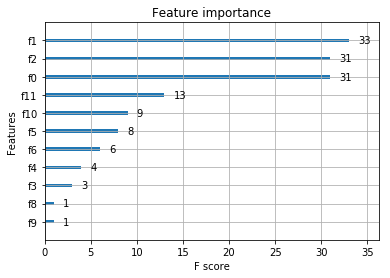

Feature Mapping:
f0 	:  Eigen Projection 1
f1 	:  Eigen Projection 2
f2 	:  Eigen Projection 3
f3 	:  Eigen Projection 4
f4 	:  Eigen Projection 5
f5 	:  Eigen Projection 6
f6 	:  Eigen Projection 7
f7 	:  Eigen Projection 8
f8 	:  Eigen Projection 9
f9 	:  Eigen Projection 10
f10 	:  RMSE
f11 	:  Peak2Peak


In [41]:
features_map = {'f0' : 'Eigen Projection 1', 'f1' : 'Eigen Projection 2',
                'f2' : 'Eigen Projection 3', 'f3' : 'Eigen Projection 4',
                'f4' : 'Eigen Projection 5', 'f5' : 'Eigen Projection 6',
                'f6' : 'Eigen Projection 7', 'f7' : 'Eigen Projection 8',
                'f8' : 'Eigen Projection 9', 'f9' : 'Eigen Projection 10',
                'f10' : 'RMSE', 'f11' : 'Peak2Peak'}

print("100 Iterations")
visualize_features(bst, features_map)

print("\n\n\n1000 Iterations")
visualize_features(bst1000, features_map)

Clearly, Eigen Projection 2, Eigen Projection 3, Eigen Projection 1, RMSE and Peak2Peak are the most important features.

# Margin Plots on Test Data

In [ ]:
import pickle

p = pickle.load(open('output.pk', 'rb'))

y_test = np.array(p['y_test'], dtype = int)
y_pred_100 = p['y_pred_100']
y_pred_1000 = p['y_pred_1000']

In [42]:
y_pred_100 = bst.predict(dtest, ntree_limit=bst.best_ntree_limit, output_margin=True)
y_pred_1000 = bst1000.predict(dtest, ntree_limit=bst1000.best_ntree_limit, output_margin=True)
y_test = dtest.get_label()

In [43]:
import matplotlib.pyplot as plt
def get_margin_plot(y_pred, y_test, thresholds, legends = None, title=None, style=['b', 'r']):
    accuracy_1 = []
    accuracy_0 = []
    for thresh in thresholds:
        y_test_i = y_test[y_test == 1]
        y_pred_i = y_pred[y_test == 1]
        correct = np.sum(y_pred_i > thresh)
        accuracy_1.append(1.0 * correct / len(y_test_i))

        y_test_i = y_test[y_test == 0]
        y_pred_i = y_pred[y_test == 0]
        correct = np.sum(y_pred_i <= thresh)
        accuracy_0.append(1.0 * correct / len(y_test_i))
    
    error_1 = list(1 - np.array(accuracy_1))
    error_0 = list(1 - np.array(accuracy_0))
    
    plt.plot(thresholds/(np.max(thresholds) - np.min(thresholds)), error_1, style[0])
    plt.plot(thresholds/(np.max(thresholds) - np.min(thresholds)), error_0, style[1])
    if legends:
        plt.legend(legends)
    plt.xlabel('Margin Score')
    plt.ylabel('Error %')
    if title:
        plt.title(title)

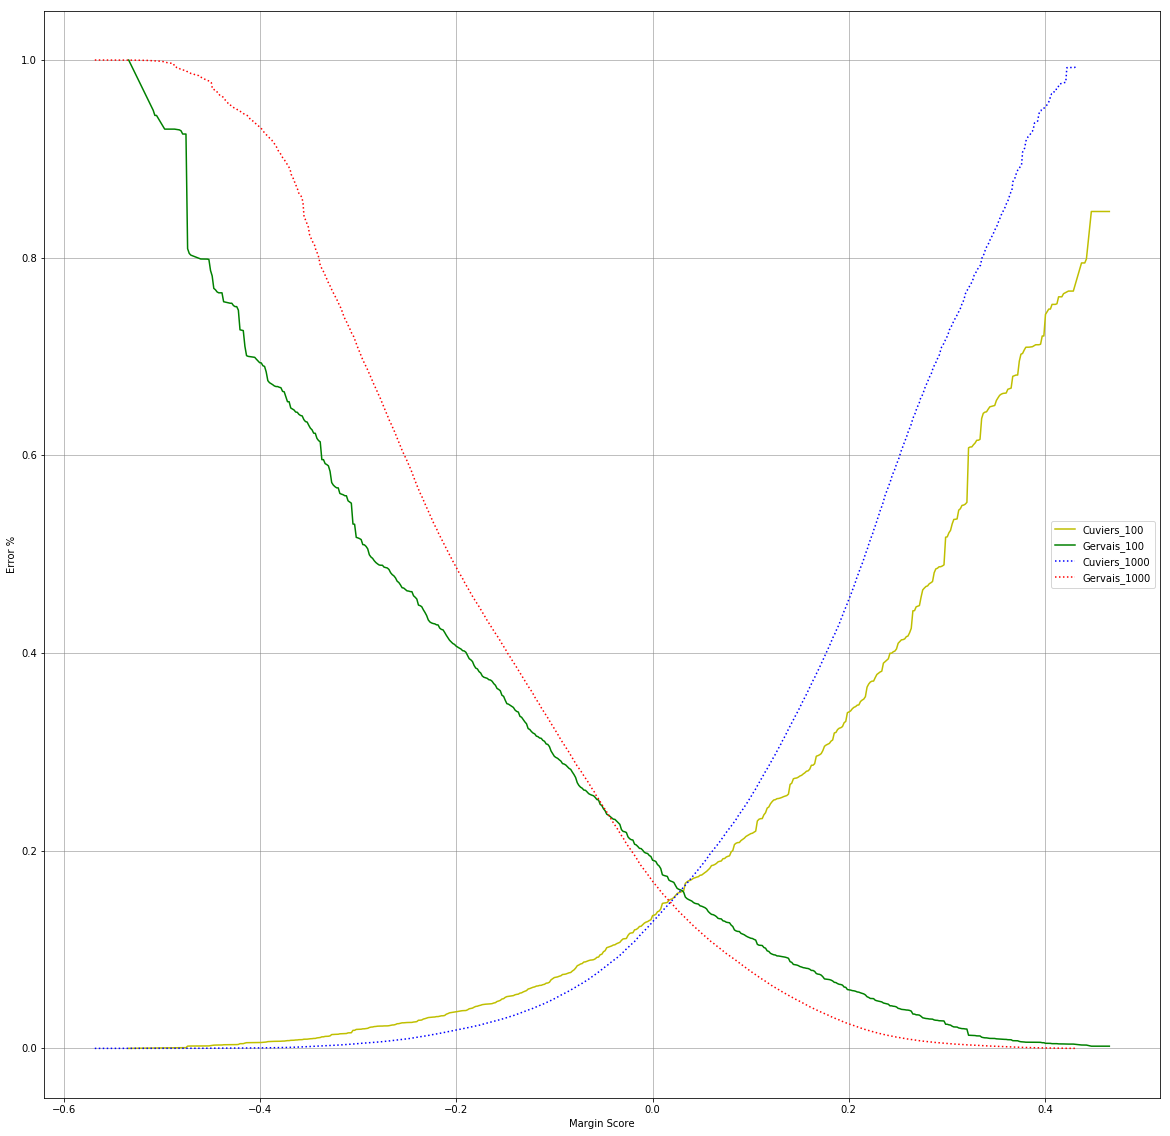

In [44]:
plt.figure(figsize=(20, 20))

## For 100 iterations
legends = ['Cuviers_100', 'Gervais_100']
thresholds = sorted(np.unique(np.round(y_pred_100, 2)))
get_margin_plot(y_pred_100, y_test, thresholds, legends = legends, style=['y', 'g'])

## For 1000 interations
legends = legends + ['Cuviers_1000', 'Gervais_1000']
thresholds = sorted(np.unique(np.round(y_pred_1000, 2)))
get_margin_plot(y_pred_1000, y_test, thresholds, legends = legends, style=['b:', 'r:'])

plt.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.show()

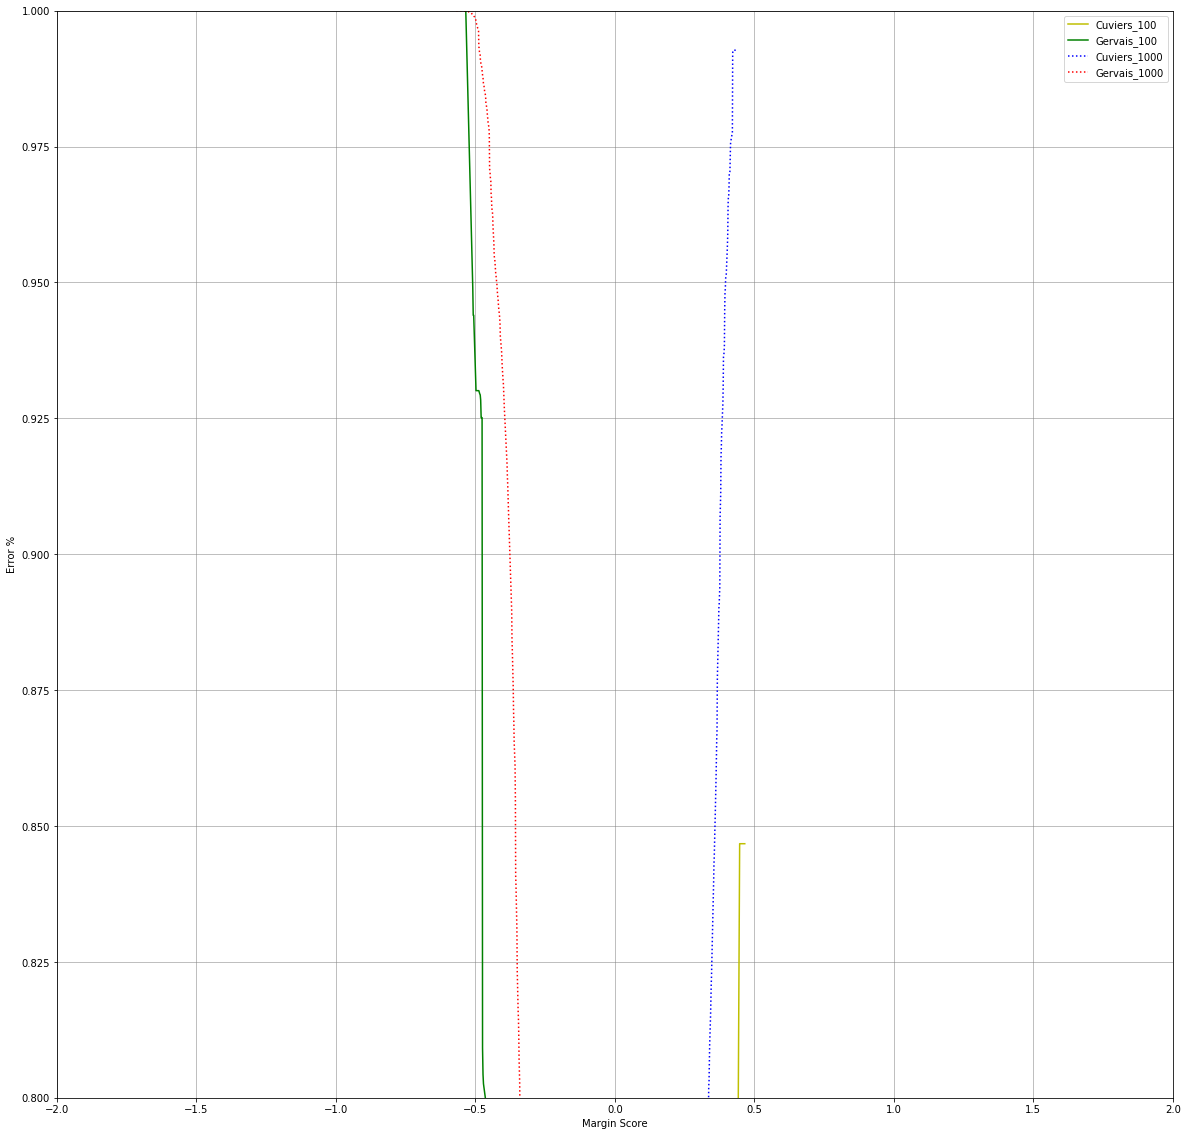

In [45]:
plt.figure(figsize=(20, 20))
legends = ['Cuviers_100', 'Gervais_100']
thresholds = sorted(np.unique(np.round(y_pred_100, 2)))
get_margin_plot(y_pred_100, y_test, thresholds, legends = legends, style=['y', 'g'])

legends = legends + ['Cuviers_1000', 'Gervais_1000']
thresholds = sorted(np.unique(np.round(y_pred_1000, 2)))
get_margin_plot(y_pred_1000, y_test, thresholds, legends = legends, style=['b:', 'r:'])

plt.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

plt.xlim([-2, 2])
plt.ylim([0.8, 1])
plt.show()

## ROC Curve

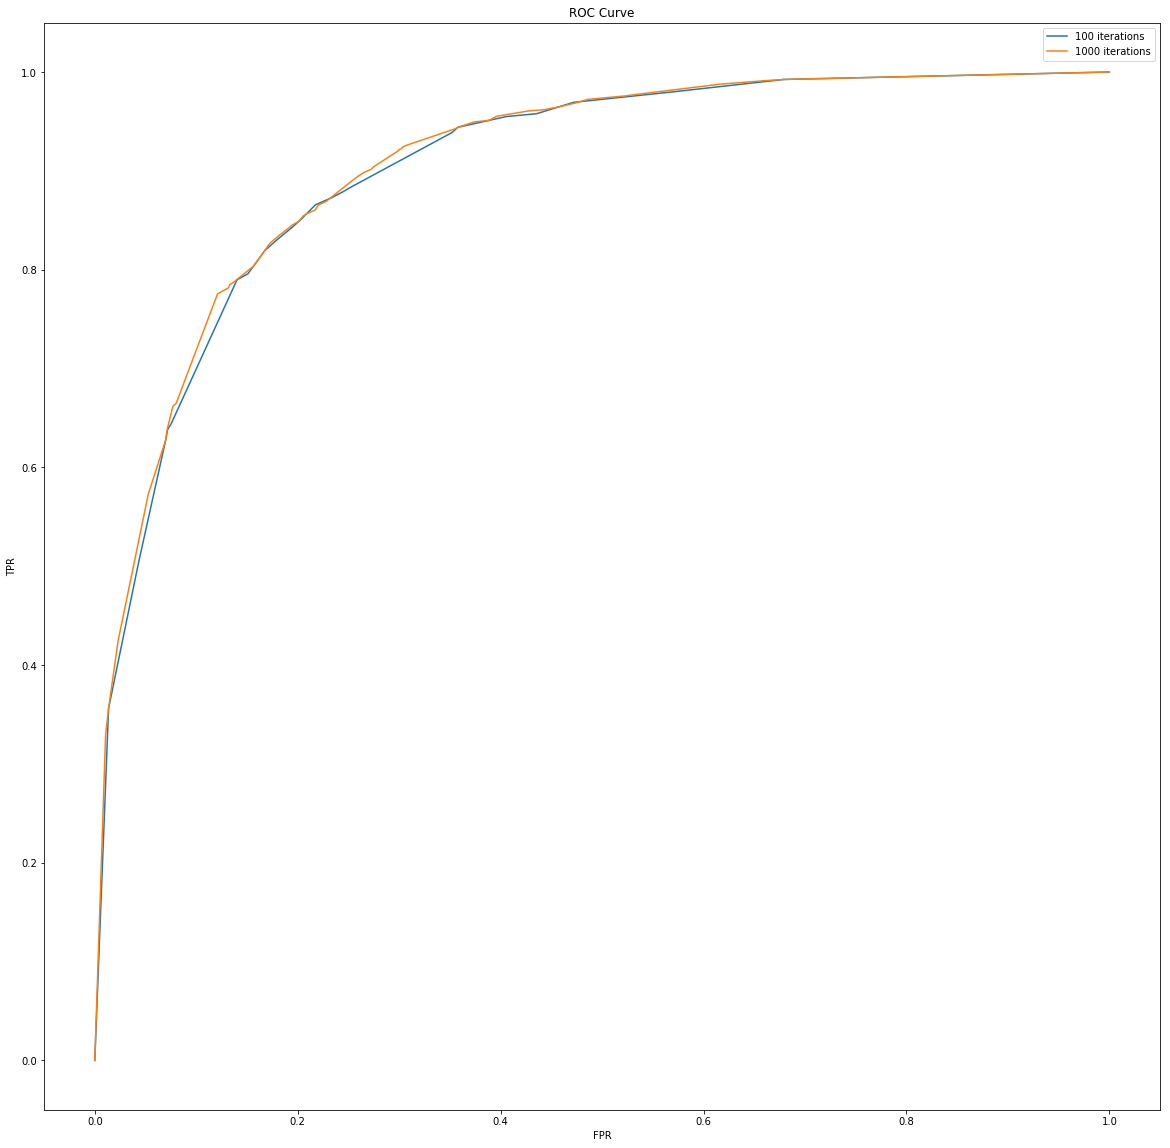

In [26]:
from sklearn.metrics import roc_curve
plt.figure(figsize=(20, 20))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_100)
plt.plot(fpr, tpr)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_1000)
plt.plot(fpr, tpr)
plt.legend(['100 iterations','1000 iterations'])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("ROC Curve")
plt.show()

# ROC Analysis

In [27]:
def statistics(y_pred, y_test, thr_lower, thr_upper):
    true_index = y_pred > thr_upper
    y_true =  np.sum(y_test[true_index] == 1)
    
    false_index = y_pred < thr_lower
    y_false =  np.sum(y_test[false_index] == 0)
    
    abstain = 1 - np.sum((y_pred < thr_lower) | (y_pred > thr_upper))/len(y_test)
    
    
    
    return (y_true+ y_false)/(len(y_test[true_index])+len(y_test[false_index])) , y_true/len(y_test[true_index]), y_false/len(y_test[false_index]), abstain

In [33]:
thr_lower_index = np.min(np.where((tpr > 0.95) & (fpr > 0.4)))
thr_upper_index = np.max(np.where((tpr < 0.5) & (fpr  < 0.05)))
thr_lower, thr_upper = thresholds[thr_lower_index], thresholds[thr_upper_index]
print("Thresholds:", thr_lower, thr_upper)
acc,cuvier_acc, gervais_acc, abstain = statistics(y_pred_1000, y_test, thr_lower, thr_upper)
print("Accuracy: %f,\nCuvier Accuracy: %f,\nGervais Accuracy: %f,\nAbstain: %f" % (acc, cuvier_acc, gervais_acc, abstain))
print("\n\n\n")


thr_lower_index = np.min(np.where((tpr > 0.95)))
thr_upper_index = np.max(np.where((tpr  < 0.6)))
thr_lower, thr_upper = thresholds[thr_lower_index], thresholds[thr_upper_index]
print("Thresholds:", thr_lower, thr_upper)
acc,cuvier_acc, gervais_acc, abstain = statistics(y_pred_1000, y_test, thr_lower, thr_upper)
print("Accuracy: %f,\nCuvier Accuracy: %f,\nGervais Accuracy: %f,\nAbstain: %f" % (acc, cuvier_acc, gervais_acc, abstain))
print("\n\n\n")


thr_lower_index = np.min(np.where((tpr > 0.92)))
thr_upper_index = np.max(np.where((tpr  < 0.3)))
thr_lower, thr_upper = thresholds[thr_lower_index], thresholds[thr_upper_index]
print("Thresholds:", thr_lower, thr_upper)
acc,cuvier_acc, gervais_acc, abstain = statistics(y_pred_1000, y_test, thr_lower, thr_upper)
print("Accuracy: %f,\nCuvier Accuracy: %f,\nGervais Accuracy: %f,\nAbstain: %f" % (acc, cuvier_acc, gervais_acc, abstain))
print("\n\n\n")

Thresholds: -0.7221638 1.0650095
Accuracy: 0.943647,
Cuvier Accuracy: 0.967693,
Gervais Accuracy: 0.927260,
Abstain: 0.515862




Thresholds: -0.55302477 0.91058576
Accuracy: 0.932539,
Cuvier Accuracy: 0.954726,
Gervais Accuracy: 0.915889,
Abstain: 0.446815




Thresholds: -0.2910995 2.2843878
Accuracy: 0.884779,
Cuvier Accuracy: nan,
Gervais Accuracy: 0.884779,
Abstain: 0.630019






/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':
